In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()


,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()


,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [4]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
# YOUR CODE HERE!
yen_futures["Return"]=yen_futures["Settle"].pct_change()*100
yen_futures["Return"].replace("inf", "nan")
yen_futures.dropna(subset=["Return"],inplace=True)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return
Date,,,,,,,,,
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0,0.584197
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0,1.756933
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0,-0.827626
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0,0.129496
1990-01-09,6918.0,6927.0,6892.0,6915.0,NaN,6915.0,29784.0,52111.0,-0.632275


### Lagged Returns 

In [5]:
# Create a lagged return using the shift function
# YOUR CODE HERE!
yen_futures["Lagged_Return"]=yen_futures.Return.shift()
yen_futures.dropna(subset=["Lagged_Return"],inplace=True)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0,1.756933,0.584197
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0,-0.827626,1.756933
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0,0.129496,-0.827626
1990-01-09,6918.0,6927.0,6892.0,6915.0,NaN,6915.0,29784.0,52111.0,-0.632275,0.129496
1990-01-10,6905.0,6940.0,6885.0,6887.0,NaN,6887.0,34290.0,54735.0,-0.404917,-0.632275


### Train Test Split

In [6]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2017']
test = yen_futures['2018':]


In [12]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
# YOUR CODE HERE!
X_train=train["Lagged_Return"].values.reshape(-1,1)
X_test=test["Lagged_Return"].values.reshape(-1,1)
y_train=train["Return"]
y_test=test["Return"]


In [13]:
y_test.head()

Date
2018-01-02    0.297285
2018-01-03   -0.240479
2018-01-04   -0.213028
2018-01-05   -0.353933
2018-01-08    0.062017
Name: Return, dtype: float64

In [15]:
X_train

array([[ 0.58419746],
       [ 1.75693335],
       [-0.82762557],
       ...,
       [ 0.11822993],
       [-0.1518304 ],
       [ 0.18022077]])

# Linear Regression Model

In [16]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
# YOUR CODE HERE!
model.fit(X_train,y_train)


LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [26]:
# Make a prediction of "y" values using just the test dataset
# YOUR CODE HERE!
predictions=model.predict(X_test)
index=test.index
predictions=pd.DataFrame(predictions,columns=["predictions"],index=index)

,predictions
Date,
2018-01-02,0.003815
2018-01-03,0.003046
2018-01-04,0.008759
2018-01-05,0.008467
2018-01-08,0.009964
...,...
2019-10-09,0.004388
2019-10-10,0.010566
2019-10-11,0.010129


In [29]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
# YOUR CODE HERE!
predictions_compare=pd.concat([predictions,y_test],axis=1)
predictions_compare

,predictions,Return
Date,,
2018-01-02,0.003815,0.297285
2018-01-03,0.003046,-0.240479
2018-01-04,0.008759,-0.213028
2018-01-05,0.008467,-0.353933
2018-01-08,0.009964,0.062017
...,...,...
2019-10-09,0.004388,-0.410601
2019-10-10,0.010566,-0.369458
2019-10-11,0.010129,-0.564304


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

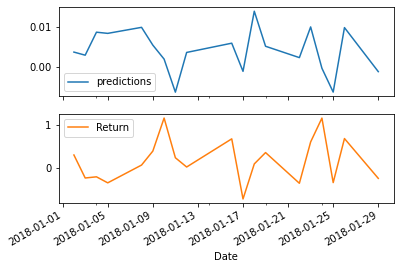

In [31]:
# Plot the first 20 predictions vs the true values
# YOUR CODE HERE!
predictions_compare.iloc[:19].plot(subplots=True)


# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [34]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# YOUR CODE HERE!
mse_predict=mean_squared_error(predictions,y_test)
# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
# YOUR CODE HERE!
import numpy as np
rmse = np.sqrt(mse_predict)

print(f"The mean squared error of out-of-sample is {mse_predict}.")
print(f"The root mean squared error of out-of-sample is {rmse}.")


The mean squared error is 0.1711067337237333.
The root mean squared error is 0.4136504970669482.


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [38]:
# Construct a dataframe using just the "y" training data:
# YOUR CODE HERE!

# Add a column of "in-sample" predictions to that dataframe:  
# YOUR CODE HERE!
predictions_train=model.predict(X_train)
index=train.index
predictions_train=pd.DataFrame(predictions_train,columns=["predictions"],index=index)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
# YOUR CODE HERE!
mse_predict_train=mean_squared_error(predictions_train,y_train)
# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
# YOUR CODE HERE!
import numpy as np
rmse = np.sqrt(mse_predict_train)
# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
# YOUR CODE HERE!
print(f"The mean squared error of in-sample is {mse_predict}.")
print(f"The root mean squared error of in-sample is {rmse}.")

The mean squared error of in-sample is 0.1711067337237333.
The root mean squared error of in-sample is 0.7059387714146013.


# Conclusions

YOUR CONCLUSIONS HERE!